In [88]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import warnings
from nltk import word_tokenize, pos_tag, FreqDist, SnowballStemmer
from nltk.corpus import wordnet as wn, stopwords
from gensim import corpora, models
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import pipeline
from wordcloud import WordCloud
from nltk.util import ngrams

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [3]:
userComments1 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (0-100k).csv')
userComments2 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (100-200k).csv')
userComments3 = pd.read_csv('C:/Users/Michael/Documents/GitHub/EBAC/dataSources/videoGames/metacritic_game_user_comments (200-300k).csv')

userComments3['Unnamed: 0'] = userComments3['Unnamed: 0'].astype('float64')
userComments3['Userscore'] = userComments3['Userscore'].astype('float64')

userComments = pd.concat([userComments1, userComments2, userComments3], axis = 0)
userComments.drop(columns = 'Unnamed: 0', inplace = True)
userComments.dropna(how = 'all', inplace = True)

userComments.Platform.unique()

platformMap = {
'Nintendo64': 'Nintendo',
'GameBoyAdvance': 'Nintendo',
'3DS': 'Nintendo',
'DS': 'Nintendo',
'Wii': 'Nintendo',
'Switch': 'Nintendo',
'WiiU': 'Nintendo',
'GameCube': 'Nintendo',
'PlayStation': 'PlayStation',
'PlayStation3': 'PlayStation',
'PlayStation2': 'PlayStation',
'PlayStation4': 'PlayStation',
'PlayStationVita': 'PlayStation',
'PSP': 'PlayStation',
'Xbox360': 'Xbox',
'Xbox': 'Xbox',
'XboxOne': 'Xbox',
'PC': 'PC',
'Dreamcast': 'Others',
'not specified': 'Others'
}

userComments['platformCondensed'] = userComments.Platform.map(platformMap)

In [4]:
# TO REMOVE EVENTUALLY!!
userComments = userComments.sample(500).copy()

In [168]:
filter_list = ["would", "could", "left", "right", "a.m.", "p.m.", "'s", "...", ":", ";", "n't", "game", "games", "play", "fun", "much", "one", "great"]

def preprocess_text(tokens, needtokenizeBoolean = True, grams = False,  ngramsNummber = 2, preProcessNgrams = False):
    if needtokenizeBoolean:
        tokens = nltk.word_tokenize(tokens)
        if grams:
            tokens = list(ngrams(tokens, ngramsNummber))
    if grams:
        tokens = [' '.join(gram) for gram in tokens]
        if preProcessNgrams == False:
            return tokens
        else:
            pass
            
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t not in stopwords.words('english') + filter_list]
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if not t.isnumeric()]
    snowball = SnowballStemmer('english')
    tokens = [snowball.stem(t) for t in tokens]
    
    return tokens

def wc(df, columnName, preProcessingFunctionBoolean = True, tfidfVectorizerBoolean = True,
       nounTaggingBoolean = False, universalNounTagsetBoolean = False, ngrams = False, ngramsNummber = 2, preProcessNgrams = False,
       top = 10, features_improvements = 'Word Cloud', platform = 'All'):

    if preProcessingFunctionBoolean == True & ngrams == True:
        if tfidfVectorizerBoolean == True:
            if preProcessNgrams == True:
                tdm = TfidfVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber, preProcessNgrams = True), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = TfidfVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
        else:
            if preProcessNgrams == True:
                tdm = CountVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber, preProcessNgrams = True), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = CountVectorizer(tokenizer=lambda text: preprocess_text(text, grams=True, ngramsNummber=ngramsNummber), min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
        tdmMatrix = tdm.fit_transform(df[columnName])
    
    if nounTaggingBoolean == True and ngrams == False:
        noun_list = []
        for value in df[columnName]:
            if universalNounTagsetBoolean == True:
                tagged_value = pos_tag(word_tokenize(value), tagset='universal')
                noun = [word for word, tag in tagged_value if tag == 'NOUN']
            else:
                tagged_value = pos_tag(word_tokenize(value))
                noun = [word for word, tag in tagged_value if tag == 'NN' or tag == 'NNS']
            noun_list.append(noun)
        df['Text_NounOnly'] = noun_list
        if preProcessingFunctionBoolean == True:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: preprocess_text(tokens = x, needtokenizeBoolean=False))
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        else:
            df['Text_NounOnly'] = df['Text_NounOnly'].apply(lambda x: ', '.join(x))
        if tfidfVectorizerBoolean == True:
            tdm = TfidfVectorizer(min_df = 2, max_df=0.7) # min_df = 2, max_df=0.7
        else:
            tdm = CountVectorizer(min_df = 2, max_df=0.7) # min_df = 2, max_df=0.7
        tdmMatrix = tdm.fit_transform(df['Text_NounOnly'])
    if nounTaggingBoolean != True and ngrams == False:
        if tfidfVectorizerBoolean == True:
            if preProcessingFunctionBoolean == True:
                tdm = TfidfVectorizer(tokenizer = preprocess_text, min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = TfidfVectorizer()
        else:
            if preProcessingFunctionBoolean == True:
                tdm = CountVectorizer(tokenizer = preprocess_text, min_df = 2, max_df=0.7) # , min_df = 2, max_df=0.7
            else:
                tdm = CountVectorizer()
        tdmMatrix = tdm.fit_transform(df[columnName])

    array = tdmMatrix.toarray()
    feature_names = tdm.get_feature_names_out()
    word_tfidf = dict(zip(feature_names, array.sum(axis=0)))
    fd_tfidf= FreqDist(word_tfidf)
    wc = WordCloud(background_color="white").generate_from_frequencies(fd_tfidf)
    plt.figure()
    plt.suptitle(f"{features_improvements} ({platform})", fontsize = 20, x = 0.5, y = 0.85, fontweight = 'bold', fontname = 'Calibri') 
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    displayList = []
    for x,y in fd_tfidf.most_common(top):
        displayList.append((x, round(y, 2)))

    plt.show()
    print(displayList)

In [18]:
userCommentsNotNull = userComments[userComments.Comment.notnull()]

userCommentsNotNull.loc[userCommentsNotNull.Userscore > 7, 'scoreBin'] = 'High'
userCommentsNotNull.loc[(userCommentsNotNull.Userscore >= 4) & (userCommentsNotNull.Userscore <= 7), 'scoreBin'] = 'Medium'
userCommentsNotNull.loc[userCommentsNotNull.Userscore < 4, 'scoreBin'] = 'Low'

userCommentsHigh = userCommentsNotNull[userCommentsNotNull.scoreBin == 'High']
userCommentsLow = userCommentsNotNull[userCommentsNotNull.scoreBin == 'Low']

print(f"High counts: {userCommentsHigh.shape[0]}\nLow counts: {userCommentsLow.shape[0]}")

High counts: 338
Low counts: 79


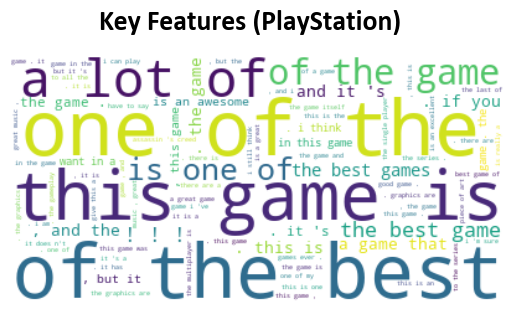

[('one of the', 3.42), ('of the best', 3.41), ('this game is', 3.2), ('a lot of', 2.5), ('of the game', 2.4), ('is one of', 2.32), ('the best game', 2.24), ('! ! !', 2.05), ('the best games', 1.99), ('. this is', 1.84)]


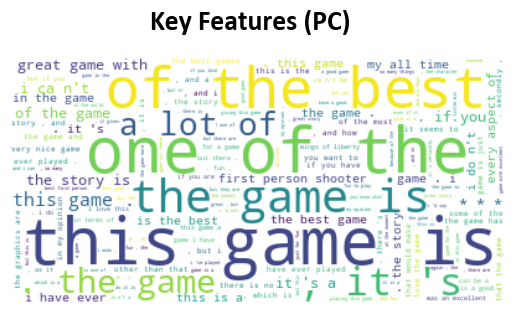

[('this game is', 4.15), ('one of the', 3.77), ('of the best', 2.96), ('the game is', 2.62), (", it 's", 2.31), ('. the game', 2.11), ('a lot of', 2.03), ('this game .', 1.93), ('great game with', 1.85), ('* * *', 1.81)]


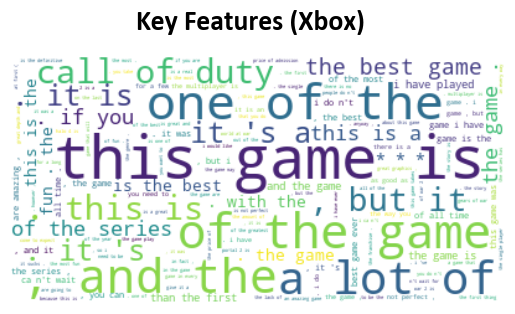

[('this game is', 3.3), ('one of the', 2.06), ('of the game', 1.97), (', and the', 1.91), ('a lot of', 1.78), ('call of duty', 1.76), ('. this is', 1.75), (', but it', 1.66), ("it 's a", 1.46), (". it 's", 1.46)]


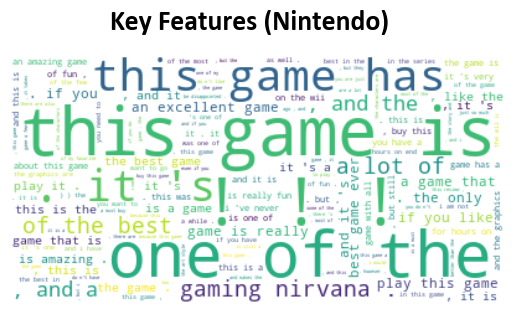

[('this game is', 2.78), ('! ! !', 2.68), ('one of the', 2.44), ('this game has', 1.85), (". it 's", 1.76), ('gaming nirvana .', 1.73), ('of the best', 1.66), ('a lot of', 1.64), (', and a', 1.5), (', and the', 1.42)]


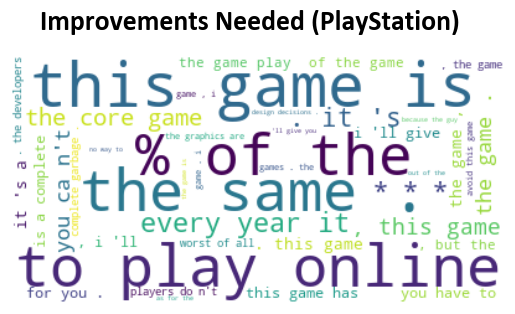

[('this game is', 1.92), ('to play online', 1.71), ('the same .', 1.69), ('% of the', 1.61), ('every year it', 1.6), (". it 's", 1.4), ('* * *', 1.32), ('the core game', 1.31), (', this game', 1.23), ('the game .', 1.15)]


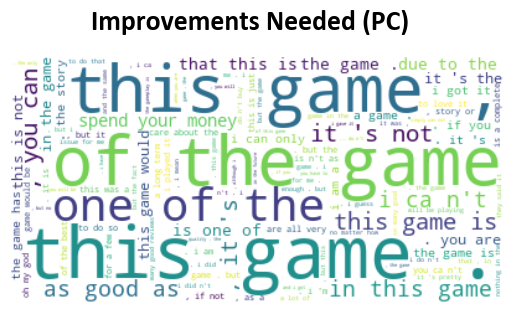

[('this game .', 1.76), ('of the game', 1.59), ('this game ,', 1.52), ('one of the', 1.51), ('this game is', 1.47), (', you can', 1.43), ("it 's not", 1.37), (", it 's", 1.24), ('in this game', 1.22), ('as good as', 1.22)]


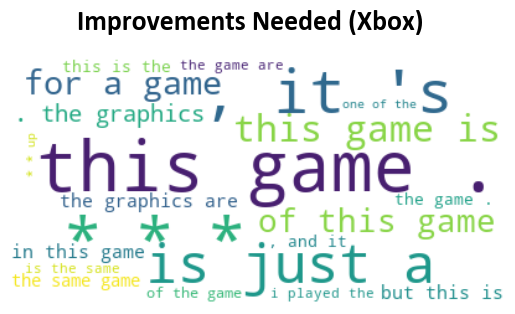

[('this game .', 2.25), (", it 's", 1.71), ('* * *', 1.7), ('is just a', 1.33), ('this game is', 1.27), ('for a game', 1.02), ('of this game', 1.02), ('. the graphics', 0.93), ('the graphics are', 0.93), ('in this game', 0.93)]


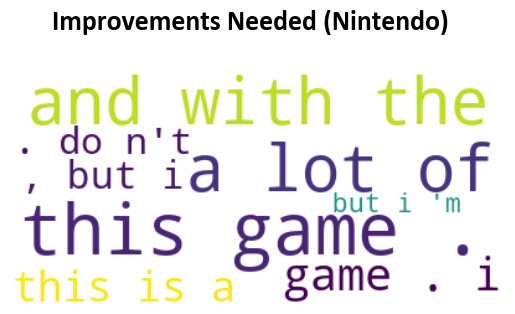

[('this game .', 1.11), ('a lot of', 0.96), ('and with the', 0.96), ('game . i', 0.79), ('this is a', 0.79), (', but i', 0.67), (". do n't", 0.67), ("but i 'm", 0.67)]
CPU times: total: 1.16 s
Wall time: 1.96 s


In [176]:
%%time

# if ngrams = True, preProcessingFunctionBoolean needs to be True 

userCommentsExtreme_list = [userCommentsHigh, userCommentsLow]
platformCondensed_list = list(userCommentsNotNull[userCommentsNotNull.scoreBin != 'Medium'].platformCondensed.unique())

for df in userCommentsExtreme_list:
    for platform in platformCondensed_list:
            if df.scoreBin.max() == 'High':
                features_improvements = 'Key Features'
            elif df.scoreBin.max() == 'Low':
                features_improvements = 'Improvements Needed'
            wc(df = df[df.platformCondensed == platform], columnName = 'Comment', preProcessingFunctionBoolean = True,
                    ngrams = True, ngramsNummber = 3, preProcessNgrams = False, tfidfVectorizerBoolean = True, top = 10,
                    nounTaggingBoolean = True, universalNounTagsetBoolean = False,
                    features_improvements = features_improvements, platform = platform)